#### About
Machine learning using Apache spark
- Dataset : https://www.kaggle.com/code/dansbecker/classification

- Use pyspark.ml on pyspark.sql.dataframe.DataFrame whereas deprecated mllib for RDD

In [287]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier, LinearSVC, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, count, isnan, when
import pyspark.pandas as pd
import itertools
from pyspark.sql.types import IntegerType,FloatType
import matplotlib.pyplot as plt
import numpy as np



In [258]:
spark = SparkSession.builder.appName('Employee Promotion Classifier').getOrCreate()

In [259]:
#reading dataset
df = spark.read.csv("/home/suraj/ClickUp/Mar-Apr/data/train.csv",header=True)

In [260]:
type(df)

pyspark.sql.dataframe.DataFrame

In [261]:
df.show()

+-----------+-----------------+---------+----------------+------+-------------------+---------------+---+--------------------+-----------------+-----------+------------------+-----------+
|employee_id|       department|   region|       education|gender|recruitment_channel|no_of_trainings|age|previous_year_rating|length_of_service|awards_won?|avg_training_score|is_promoted|
+-----------+-----------------+---------+----------------+------+-------------------+---------------+---+--------------------+-----------------+-----------+------------------+-----------+
|      65438|Sales & Marketing| region_7|Master's & above|     f|           sourcing|              1| 35|                 5.0|                8|          0|                49|          0|
|      65141|       Operations|region_22|      Bachelor's|     m|              other|              1| 30|                 5.0|                4|          0|                60|          0|
|       7513|Sales & Marketing|region_19|      Bachelor's|  

In [262]:
#creating dummy values
cols =['department','region','education','gender','recruitment_channel']
for col in cols:
    categ = df.select(col).distinct().rdd.flatMap(lambda x:x).collect()
    exprs = [F.when(F.col(col) == cat,1).otherwise(0)\
            .alias(str(cat)) for cat in categ]
    df = df.select(exprs+df.columns)
df.show()

+-----+--------+--------+---+---+----+---------------+----------------+----------+---------+--------+---------+---------+---------+---------+--------+---------+--------+---------+---------+---------+---------+---------+--------+---------+---------+---------+---------+--------+---------+---------+---------+---------+--------+--------+---------+--------+---------+---------+---------+---------+--------+---------+---+-------+---------+-----+-----------------+----------+-----------+----------+---+-----------+-----------------+---------+----------------+------+-------------------+---------------+---+--------------------+-----------------+-----------+------------------+-----------+
|other|sourcing|referred|  m|  f|None|Below Secondary|Master's & above|Bachelor's|region_16|region_2|region_28|region_10|region_27|region_18|region_9|region_24|region_5|region_26|region_32|region_13|region_14|region_19|region_4|region_23|region_33|region_12|region_20|region_8|region_30|region_29|region_22|region_11

In [263]:
# dropping employee_id 
features = df.drop('employee_id')
# also department|   region|       education|gender|recruitment_channel
features = features.drop('department')
features = features.drop('region')
features = features.drop('education')
features = features.drop('gender')
features = features.drop('recruitment_channel')
features = features.drop('awards_won?')
#dropping null values
features = features.dropna()

In [264]:
features.show()

+-----+--------+--------+---+---+----+---------------+----------------+----------+---------+--------+---------+---------+---------+---------+--------+---------+--------+---------+---------+---------+---------+---------+--------+---------+---------+---------+---------+--------+---------+---------+---------+---------+--------+--------+---------+--------+---------+---------+---------+---------+--------+---------+---+-------+---------+-----+-----------------+----------+-----------+----------+---+---------------+---+--------------------+-----------------+------------------+-----------+
|other|sourcing|referred|  m|  f|None|Below Secondary|Master's & above|Bachelor's|region_16|region_2|region_28|region_10|region_27|region_18|region_9|region_24|region_5|region_26|region_32|region_13|region_14|region_19|region_4|region_23|region_33|region_12|region_20|region_8|region_30|region_29|region_22|region_11|region_1|region_7|region_25|region_3|region_21|region_31|region_15|region_17|region_6|region_34

In [265]:
features.printSchema()

root
 |-- other: integer (nullable = false)
 |-- sourcing: integer (nullable = false)
 |-- referred: integer (nullable = false)
 |-- m: integer (nullable = false)
 |-- f: integer (nullable = false)
 |-- None: integer (nullable = false)
 |-- Below Secondary: integer (nullable = false)
 |-- Master's & above: integer (nullable = false)
 |-- Bachelor's: integer (nullable = false)
 |-- region_16: integer (nullable = false)
 |-- region_2: integer (nullable = false)
 |-- region_28: integer (nullable = false)
 |-- region_10: integer (nullable = false)
 |-- region_27: integer (nullable = false)
 |-- region_18: integer (nullable = false)
 |-- region_9: integer (nullable = false)
 |-- region_24: integer (nullable = false)
 |-- region_5: integer (nullable = false)
 |-- region_26: integer (nullable = false)
 |-- region_32: integer (nullable = false)
 |-- region_13: integer (nullable = false)
 |-- region_14: integer (nullable = false)
 |-- region_19: integer (nullable = false)
 |-- region_4: integer

In [266]:
features = features.withColumn("no_of_trainings",features.no_of_trainings.cast(IntegerType()))
features.printSchema()



root
 |-- other: integer (nullable = false)
 |-- sourcing: integer (nullable = false)
 |-- referred: integer (nullable = false)
 |-- m: integer (nullable = false)
 |-- f: integer (nullable = false)
 |-- None: integer (nullable = false)
 |-- Below Secondary: integer (nullable = false)
 |-- Master's & above: integer (nullable = false)
 |-- Bachelor's: integer (nullable = false)
 |-- region_16: integer (nullable = false)
 |-- region_2: integer (nullable = false)
 |-- region_28: integer (nullable = false)
 |-- region_10: integer (nullable = false)
 |-- region_27: integer (nullable = false)
 |-- region_18: integer (nullable = false)
 |-- region_9: integer (nullable = false)
 |-- region_24: integer (nullable = false)
 |-- region_5: integer (nullable = false)
 |-- region_26: integer (nullable = false)
 |-- region_32: integer (nullable = false)
 |-- region_13: integer (nullable = false)
 |-- region_14: integer (nullable = false)
 |-- region_19: integer (nullable = false)
 |-- region_4: integer

In [267]:
features = features.withColumn("age",features.age.cast(IntegerType()))
features.printSchema()



root
 |-- other: integer (nullable = false)
 |-- sourcing: integer (nullable = false)
 |-- referred: integer (nullable = false)
 |-- m: integer (nullable = false)
 |-- f: integer (nullable = false)
 |-- None: integer (nullable = false)
 |-- Below Secondary: integer (nullable = false)
 |-- Master's & above: integer (nullable = false)
 |-- Bachelor's: integer (nullable = false)
 |-- region_16: integer (nullable = false)
 |-- region_2: integer (nullable = false)
 |-- region_28: integer (nullable = false)
 |-- region_10: integer (nullable = false)
 |-- region_27: integer (nullable = false)
 |-- region_18: integer (nullable = false)
 |-- region_9: integer (nullable = false)
 |-- region_24: integer (nullable = false)
 |-- region_5: integer (nullable = false)
 |-- region_26: integer (nullable = false)
 |-- region_32: integer (nullable = false)
 |-- region_13: integer (nullable = false)
 |-- region_14: integer (nullable = false)
 |-- region_19: integer (nullable = false)
 |-- region_4: integer

In [268]:
features = features.withColumn("previous_year_rating",features.previous_year_rating.cast(IntegerType()))
features.printSchema()


root
 |-- other: integer (nullable = false)
 |-- sourcing: integer (nullable = false)
 |-- referred: integer (nullable = false)
 |-- m: integer (nullable = false)
 |-- f: integer (nullable = false)
 |-- None: integer (nullable = false)
 |-- Below Secondary: integer (nullable = false)
 |-- Master's & above: integer (nullable = false)
 |-- Bachelor's: integer (nullable = false)
 |-- region_16: integer (nullable = false)
 |-- region_2: integer (nullable = false)
 |-- region_28: integer (nullable = false)
 |-- region_10: integer (nullable = false)
 |-- region_27: integer (nullable = false)
 |-- region_18: integer (nullable = false)
 |-- region_9: integer (nullable = false)
 |-- region_24: integer (nullable = false)
 |-- region_5: integer (nullable = false)
 |-- region_26: integer (nullable = false)
 |-- region_32: integer (nullable = false)
 |-- region_13: integer (nullable = false)
 |-- region_14: integer (nullable = false)
 |-- region_19: integer (nullable = false)
 |-- region_4: integer

In [269]:
features = features.withColumn("length_of_service",features.length_of_service.cast(IntegerType()))
features.printSchema()


root
 |-- other: integer (nullable = false)
 |-- sourcing: integer (nullable = false)
 |-- referred: integer (nullable = false)
 |-- m: integer (nullable = false)
 |-- f: integer (nullable = false)
 |-- None: integer (nullable = false)
 |-- Below Secondary: integer (nullable = false)
 |-- Master's & above: integer (nullable = false)
 |-- Bachelor's: integer (nullable = false)
 |-- region_16: integer (nullable = false)
 |-- region_2: integer (nullable = false)
 |-- region_28: integer (nullable = false)
 |-- region_10: integer (nullable = false)
 |-- region_27: integer (nullable = false)
 |-- region_18: integer (nullable = false)
 |-- region_9: integer (nullable = false)
 |-- region_24: integer (nullable = false)
 |-- region_5: integer (nullable = false)
 |-- region_26: integer (nullable = false)
 |-- region_32: integer (nullable = false)
 |-- region_13: integer (nullable = false)
 |-- region_14: integer (nullable = false)
 |-- region_19: integer (nullable = false)
 |-- region_4: integer

In [270]:
features = features.withColumn("avg_training_score",features.avg_training_score.cast(IntegerType()))
features.printSchema()

root
 |-- other: integer (nullable = false)
 |-- sourcing: integer (nullable = false)
 |-- referred: integer (nullable = false)
 |-- m: integer (nullable = false)
 |-- f: integer (nullable = false)
 |-- None: integer (nullable = false)
 |-- Below Secondary: integer (nullable = false)
 |-- Master's & above: integer (nullable = false)
 |-- Bachelor's: integer (nullable = false)
 |-- region_16: integer (nullable = false)
 |-- region_2: integer (nullable = false)
 |-- region_28: integer (nullable = false)
 |-- region_10: integer (nullable = false)
 |-- region_27: integer (nullable = false)
 |-- region_18: integer (nullable = false)
 |-- region_9: integer (nullable = false)
 |-- region_24: integer (nullable = false)
 |-- region_5: integer (nullable = false)
 |-- region_26: integer (nullable = false)
 |-- region_32: integer (nullable = false)
 |-- region_13: integer (nullable = false)
 |-- region_14: integer (nullable = false)
 |-- region_19: integer (nullable = false)
 |-- region_4: integer

In [271]:
features = features.withColumn("is_promoted",features.is_promoted.cast(IntegerType()))
features.printSchema()

root
 |-- other: integer (nullable = false)
 |-- sourcing: integer (nullable = false)
 |-- referred: integer (nullable = false)
 |-- m: integer (nullable = false)
 |-- f: integer (nullable = false)
 |-- None: integer (nullable = false)
 |-- Below Secondary: integer (nullable = false)
 |-- Master's & above: integer (nullable = false)
 |-- Bachelor's: integer (nullable = false)
 |-- region_16: integer (nullable = false)
 |-- region_2: integer (nullable = false)
 |-- region_28: integer (nullable = false)
 |-- region_10: integer (nullable = false)
 |-- region_27: integer (nullable = false)
 |-- region_18: integer (nullable = false)
 |-- region_9: integer (nullable = false)
 |-- region_24: integer (nullable = false)
 |-- region_5: integer (nullable = false)
 |-- region_26: integer (nullable = false)
 |-- region_32: integer (nullable = false)
 |-- region_13: integer (nullable = false)
 |-- region_14: integer (nullable = false)
 |-- region_19: integer (nullable = false)
 |-- region_4: integer

In [272]:
features.show()

+-----+--------+--------+---+---+----+---------------+----------------+----------+---------+--------+---------+---------+---------+---------+--------+---------+--------+---------+---------+---------+---------+---------+--------+---------+---------+---------+---------+--------+---------+---------+---------+---------+--------+--------+---------+--------+---------+---------+---------+---------+--------+---------+---+-------+---------+-----+-----------------+----------+-----------+----------+---+---------------+---+--------------------+-----------------+------------------+-----------+
|other|sourcing|referred|  m|  f|None|Below Secondary|Master's & above|Bachelor's|region_16|region_2|region_28|region_10|region_27|region_18|region_9|region_24|region_5|region_26|region_32|region_13|region_14|region_19|region_4|region_23|region_33|region_12|region_20|region_8|region_30|region_29|region_22|region_11|region_1|region_7|region_25|region_3|region_21|region_31|region_15|region_17|region_6|region_34

In [273]:
input_features = features.drop('is_promoted')

In [274]:
assembler = VectorAssembler( inputCols=input_features.columns,outputCol="features")

In [275]:
output = assembler.transform(features)

In [276]:
output.show()

+-----+--------+--------+---+---+----+---------------+----------------+----------+---------+--------+---------+---------+---------+---------+--------+---------+--------+---------+---------+---------+---------+---------+--------+---------+---------+---------+---------+--------+---------+---------+---------+---------+--------+--------+---------+--------+---------+---------+---------+---------+--------+---------+---+-------+---------+-----+-----------------+----------+-----------+----------+---+---------------+---+--------------------+-----------------+------------------+-----------+--------------------+
|other|sourcing|referred|  m|  f|None|Below Secondary|Master's & above|Bachelor's|region_16|region_2|region_28|region_10|region_27|region_18|region_9|region_24|region_5|region_26|region_32|region_13|region_14|region_19|region_4|region_23|region_33|region_12|region_20|region_8|region_30|region_29|region_22|region_11|region_1|region_7|region_25|region_3|region_21|region_31|region_15|region_

In [277]:
output= output.select("features", "is_promoted")
output.show()

+--------------------+-----------+
|            features|is_promoted|
+--------------------+-----------+
|(57,[1,4,7,34,47,...|          0|
|(57,[0,3,8,31,50,...|          0|
|(57,[1,3,8,22,47,...|          0|
|(57,[0,3,8,24,47,...|          0|
|(57,[0,3,8,18,48,...|          0|
|(57,[1,3,8,10,45,...|          0|
|(57,[0,4,8,27,50,...|          0|
|(57,[1,3,7,42,50,...|          0|
|(57,[0,3,8,27,45,...|          0|
|(57,[1,3,7,33,47,...|          0|
|(57,[1,4,8,34,47,...|          1|
|(57,[1,3,8,23,47,...|          0|
|(57,[0,3,7,30,48,...|          0|
|(57,[1,3,7,10,51,...|          0|
|(57,[0,3,8,34,50,...|          0|
|(57,[0,3,8,10,48,...|          0|
|(57,[0,3,8,38,47,...|          0|
|(57,[0,3,8,38,47,...|          0|
|(57,[0,3,8,39,50,...|          0|
|(57,[0,3,8,21,49,...|          0|
+--------------------+-----------+
only showing top 20 rows



In [278]:
train_df,test_df = output.randomSplit([0.7, 0.3])

In [279]:
train_df.show()
test_df.show()

+--------------------+-----------+
|            features|is_promoted|
+--------------------+-----------+
|(57,[0,3,6,9,43,5...|          0|
|(57,[0,3,6,9,48,5...|          0|
|(57,[0,3,6,9,49,5...|          0|
|(57,[0,3,6,9,50,5...|          0|
|(57,[0,3,6,9,50,5...|          0|
|(57,[0,3,6,10,43,...|          0|
|(57,[0,3,6,10,43,...|          1|
|(57,[0,3,6,10,43,...|          0|
|(57,[0,3,6,10,43,...|          0|
|(57,[0,3,6,10,43,...|          0|
|(57,[0,3,6,10,43,...|          0|
|(57,[0,3,6,10,43,...|          0|
|(57,[0,3,6,10,43,...|          0|
|(57,[0,3,6,10,43,...|          0|
|(57,[0,3,6,10,44,...|          0|
|(57,[0,3,6,10,44,...|          0|
|(57,[0,3,6,10,44,...|          0|
|(57,[0,3,6,10,44,...|          0|
|(57,[0,3,6,10,44,...|          0|
|(57,[0,3,6,10,44,...|          0|
+--------------------+-----------+
only showing top 20 rows

+--------------------+-----------+
|            features|is_promoted|
+--------------------+-----------+
|(57,[0,3,6,9,49,5...|       

In [289]:
linear_classifier = LogisticRegression(featuresCol='features', labelCol='is_promoted')
lr = linear_classifier.fit(train_df)

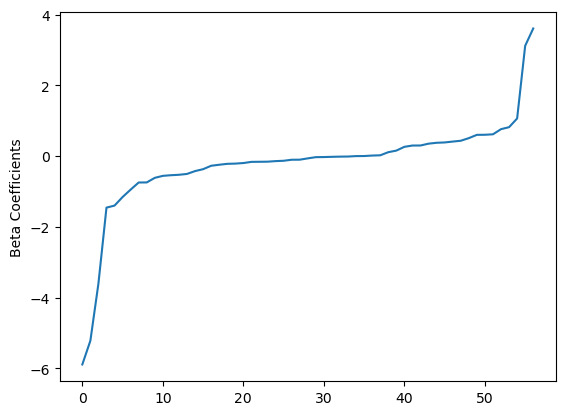

In [290]:
beta = np.sort(lr.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

Significance of ROC Curve - It is equivalent to the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance

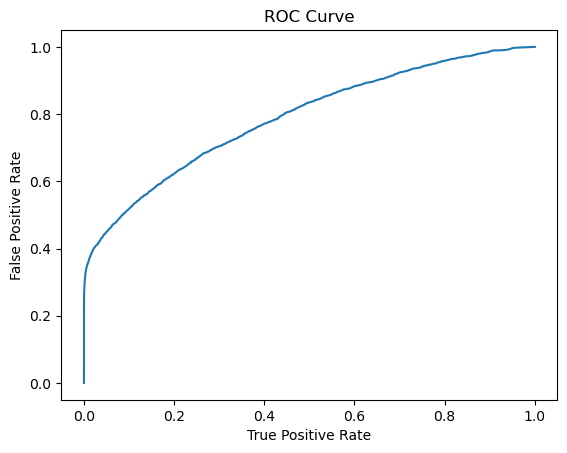

Training set areaUnderROC: 0.7889801601495677


In [291]:
trainingSummary = lr.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

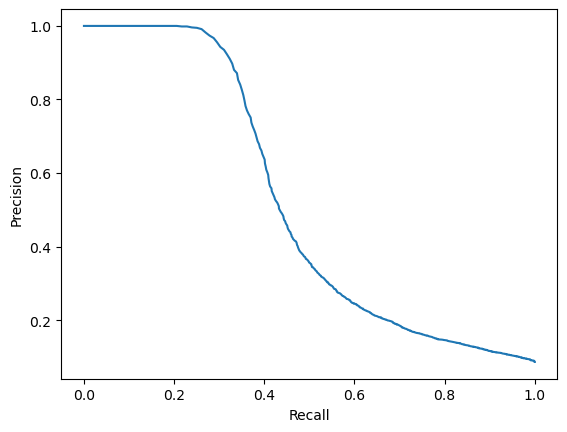

In [292]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [293]:
pred = lr.transform(test_df)


In [294]:
pred.show()

+--------------------+-----------+--------------------+--------------------+----------+
|            features|is_promoted|       rawPrediction|         probability|prediction|
+--------------------+-----------+--------------------+--------------------+----------+
|(57,[0,3,6,9,49,5...|          0|[4.00430821364343...|[0.98208972694037...|       0.0|
|(57,[0,3,6,10,43,...|          0|[3.23068371788735...|[0.96197277202254...|       0.0|
|(57,[0,3,6,10,43,...|          0|[4.57562818933939...|[0.98980517799808...|       0.0|
|(57,[0,3,6,10,43,...|          0|[4.59238785886628...|[0.98997291704799...|       0.0|
|(57,[0,3,6,10,43,...|          0|[2.79538746072533...|[0.94242606163741...|       0.0|
|(57,[0,3,6,10,44,...|          0|[3.23149338975861...|[0.96200237968086...|       0.0|
|(57,[0,3,6,10,44,...|          0|[2.06182841021018...|[0.88713736850006...|       0.0|
|(57,[0,3,6,10,44,...|          0|[4.52067031032400...|[0.98923541023868...|       0.0|
|(57,[0,3,6,10,46,...|          

In [295]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'is_promoted')
rfModel = rf.fit(train_df)
pred = rfModel.transform(test_df)
pred.show()

+--------------------+-----------+--------------------+--------------------+----------+
|            features|is_promoted|       rawPrediction|         probability|prediction|
+--------------------+-----------+--------------------+--------------------+----------+
|(57,[0,3,6,9,49,5...|          0|[18.5005257054897...|[0.92502628527448...|       0.0|
|(57,[0,3,6,10,43,...|          0|[18.5859527768889...|[0.92929763884444...|       0.0|
|(57,[0,3,6,10,43,...|          0|[18.5859527768889...|[0.92929763884444...|       0.0|
|(57,[0,3,6,10,43,...|          0|[18.5859527768889...|[0.92929763884444...|       0.0|
|(57,[0,3,6,10,43,...|          0|[18.5859527768889...|[0.92929763884444...|       0.0|
|(57,[0,3,6,10,44,...|          0|[18.5341596684055...|[0.92670798342027...|       0.0|
|(57,[0,3,6,10,44,...|          0|[18.1790851571256...|[0.90895425785628...|       0.0|
|(57,[0,3,6,10,44,...|          0|[18.5341596684055...|[0.92670798342027...|       0.0|
|(57,[0,3,6,10,46,...|          

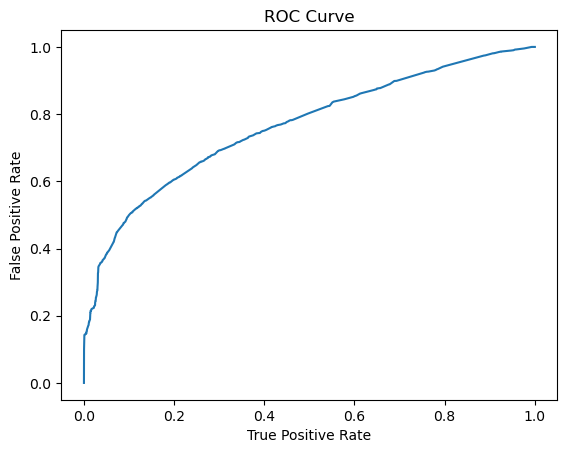

Training set areaUnderROC: 0.7634027566321316


In [297]:
trainingSummary = rfModel.summary
rfROC = trainingSummary.roc.toPandas()

plt.plot(rfROC['FPR'],rfROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))